### Loading Libraries & Configurations

In [3]:
import os
import numpy as np
import pandas as pd
import psycopg2
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import duckdb
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d
import shutil

In [2]:
#Network Libraries
import networkx as nx
from networkx.algorithms import bipartite

In [2]:
hostname = 'localhost'
port_id = '5432'
username = 'postgres'
pw = '123456789'
database = 'Open_Source_Network'

### Find CSV files in directory

In [309]:
#find csv files in my current working directory
#isolate only the csv files
csv_files = []
for file in os.listdir(os.getcwd()+'\osn_csvs'):
    if file.endswith('.csv'):
        csv_files.append(file)

In [310]:
#make a new directory
dataset_dir = 'DB_CSVs'

#create the bash command to make a new directory
try:
    mkdir = 'mkdir {0}'.format(dataset_dir)
    os.system(mkdir)
except:
    pass

In [ ]:
#move the csv files in the new directory

for csv in csv_files:
    source = os.getcwd()+'\osn_csvs'+'\\'
    destination = os.getcwd()+'\DB_CSVs'
    shutil.copy(source+'{}'.format(csv), destination)
    mv_file = "mv '{0}' {1}".format(csv, dataset_dir)
    print(mv_file)

### Create the pandas df from the CSV file

In [ ]:
data_path = os.getcwd()+'\DB_CSVs'+'\\'

df = {}
for file in csv_files:
    try:
        df[file] = pd.read(data_path+file)
    except:
        df[file] = pd.read_csv(data_path+file, encoding = 'ISO-8859-1')

### Clean table names and column names and importing tables to the DB

In [ ]:
for k in csv_files:
    dataframe = df[k]
    clean_tbl_name = k.lower().replace("avtrrt__", "").replace("_anonymized","")
    
    #remove .csv extension from clean_tbl_name
    tbl_name = '{0}'.format(clean_tbl_name.split('.')[0])
    dataframe.columns = [x.lower().replace("avtrrt__", "").replace(";", "_").replace(" ", "_").replace("__","_")\
                         .replace(">", "greater_than").replace("<","less_than").replace("-","_").replace("+","_Plus")\
                         .replace("/","_").replace(",","_").replace("&","_AND_").replace("(","").replace(")","")\
                         .replace("]","").replace("[","").replace("'","").replace("?","").replace(".","").replace("%","") for x in dataframe.columns]

    #replacement dictionary that maps pandas dtypes to sql dtypes
    replacements = {
        'object' : 'varchar',
        'float64' : 'float',
        'int64' : 'int',
        'datetime64' : 'timestamp',
        'timedelta64[ns]' : 'varchar'

    }

    #table schema
    col_str = ", ".join("{} {}".format(n, d) for (n, d) in zip(dataframe.columns, dataframe.dtypes.replace(replacements)))

    #open a database connection
    conn = None
    conn = psycopg2.connect(host = hostname, dbname = database, user = username, password = pw, port = port_id)
    cur = conn.cursor()

    #drop table with same name
    cur.execute('drop table if exists %s;' % (tbl_name))

    #create table
    cur.execute('create table %s (%s)' % (tbl_name, col_str))
    print('{0} was created successfully'.format(tbl_name))

    #insert values to table
    #save df to csv
    dataframe.to_csv(k, header = dataframe.columns, index = False, encoding = 'utf-8')

    #open the csv file, save it as an object
    my_file = open(k, encoding= 'utf-8')
    print('file opened in memory')

    #upload to db
    SQL_STATEMENT = """
    COPY %s FROM STDIN WITH
        CSV
        HEADER
        DELIMITER AS ','
    """ 

    cur.copy_expert(sql=SQL_STATEMENT % tbl_name,file=my_file)
    print('file copied to db')

    cur.execute("grant select on table %s to public" % tbl_name)
    conn.commit()
    conn.close()
    print('table {0} imported to db completed'.format(tbl_name))
        

### Selecting all features in job table to perform missing values visualization

In [38]:
conn = None
cur = None
try:
    conn = psycopg2.connect(host = hostname, dbname = database, user = username, password = pw, port = port_id)
    job_features = pd.read_sql('''SELECT * FROM "public"."job" ''', con = conn)
    conn.commit()
except Exception as error:
    print(error)
finally:
    if cur is not None:
        cur.close()
    if conn is not None:
        conn.close()

C:\Users\amrmn\AppData\Local\Temp\ipykernel_25024\92602361.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  job_features = pd.read_sql('''SELECT * FROM "public"."job" ''', con = conn)


In [ ]:
job_features.columns

In [40]:
job_features = job_features.drop(['id', 'ownerid', 'recordtypeid',
       'createdbyid', 'lastmodifieddate', 'lastmodifiedbyid',
       'systemmodstamp', 'lastactivitydate', 'account_job_c',
       'account_manager_c', 'autopopulated_skills_c', 'estimated_close_date_c',
       'hiring_manager_c',
       'recruiter_c', 'sales_manager_c', 'hired_date_c', 'start_date_c', 'ideal_start_date_permanent_c', 'ideal_start_date_contract_c'], axis=1)

In [ ]:
msno.bar(job_features)

### Generating a csv file that can be used as a skill bar plot visualization (candidate & job skills)

In [74]:
df = pd.read_csv("List_of_Skills_Job.csv")
df = df.drop(['Id'], axis=1)
df['Skills'] = df['Skills'].str.split(',')
new_df = df.explode('Skills')
new_df.to_csv('List_of_Skills_Job_exploded.csv')

In [75]:
df = pd.read_csv("candidate_list_of_skills_merged.csv")
df = df.drop(['ID'], axis=1)
df['Skills'] = df['Skills'].str.split(',')
new_df = df.explode('Skills')
new_df.to_csv('List_of_Skills_Candidate_exploded.csv')

### Recommendation System & Skills Clustering

In [50]:
def matrix_creation(df, Job_Category):
    query = duckdb.query("SELECT OSN_Practice_Focus__c, Skills, COUNT(df.Skills) AS COUNT FROM df WHERE Job_Category = '{0}' GROUP BY (df.Skills, OSN_Practice_Focus__c)".format(Job_Category)).df()
    matrix = query.pivot_table(columns='OSN_Practice_Focus__c', index='Skills', values='COUNT')
    matrix = matrix. replace(np. nan,0)
    return query, matrix

def cos_sim(matrix):
    cosine_similarity_matrix = cosine_similarity(matrix)
    df_sim = pd.DataFrame(cosine_similarity_matrix, index = matrix.index, columns= matrix.index)
    return df_sim

def get_recommendations(skill, df_sim, category):
    skill_index = df[df['Skills'] == skill].index[0]
    distances = df_sim[category].values[skill_index]
    skill_list = sorted(list(enumerate(distances)), reverse= True, key=lambda x:x[1])[1:6]

    for i in skill_list:
        print(df.iloc[i[0]].Skills)

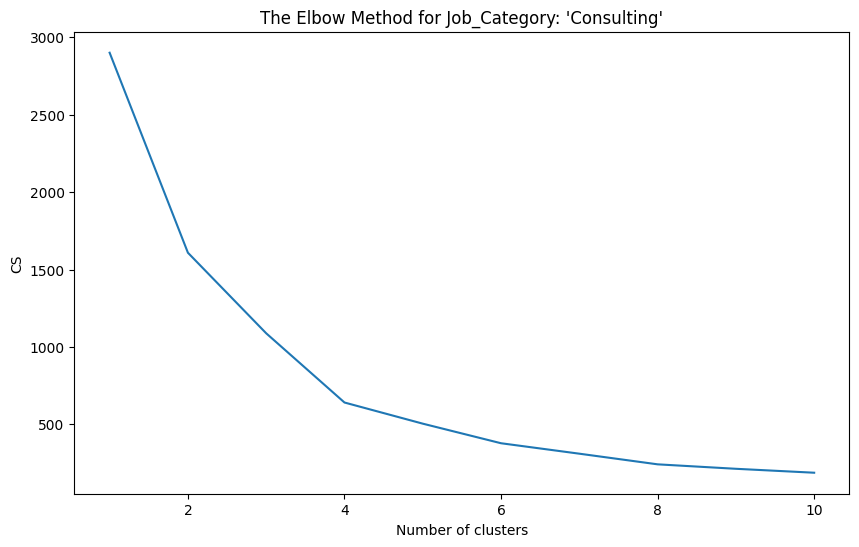

2 dimension PCA - Consulting: 1 component: 48.33% of initial variance
2 dimension PCA - Consulting: 2 component: 23.02% of initial variance
3 dimension PCA - Consulting: 1 component: 48.33% of initial variance
3 dimension PCA - Consulting: 2 component: 23.02% of initial variance
3 dimension PCA - Consulting: 3 component: 19.12% of initial variance


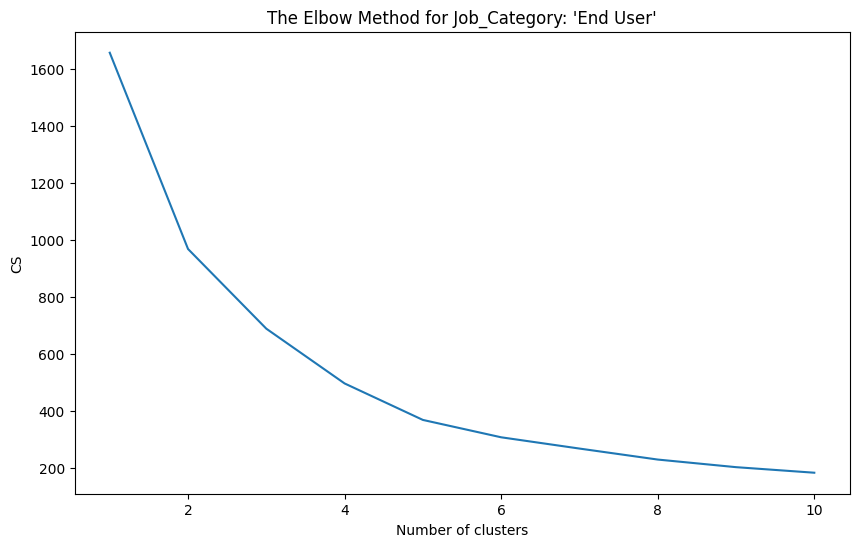

2 dimension PCA - End User: 1 component: 50.38% of initial variance
2 dimension PCA - End User: 2 component: 23.72% of initial variance
3 dimension PCA - End User: 1 component: 50.38% of initial variance
3 dimension PCA - End User: 2 component: 23.72% of initial variance
3 dimension PCA - End User: 3 component: 15.83% of initial variance


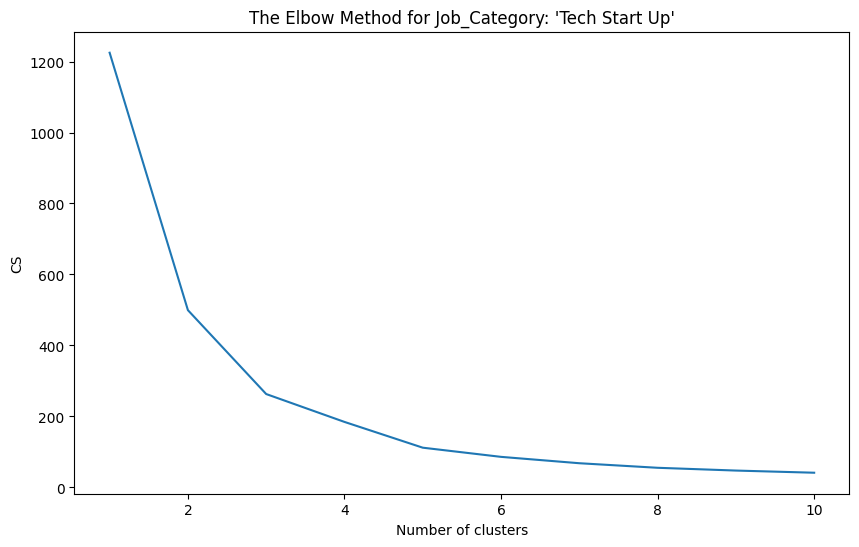

2 dimension PCA - Tech Start Up: 1 component: 66.09% of initial variance
2 dimension PCA - Tech Start Up: 2 component: 22.19% of initial variance
3 dimension PCA - Tech Start Up: 1 component: 66.09% of initial variance
3 dimension PCA - Tech Start Up: 2 component: 22.19% of initial variance
3 dimension PCA - Tech Start Up: 3 component: 8.85% of initial variance


In [6]:
list_of_skills = pd.read_csv('List_of_Skills_Job_Cleaned.csv')
osn_practice_focus = pd.read_csv('OSN_Practice_Focus.csv')
list_of_skills_df = pd.DataFrame(list_of_skills)
osn_practice_focus_df = pd.DataFrame(osn_practice_focus)
list_of_skills_df['Skills'] = list_of_skills_df['Skills'].str.split(',')
df_skills = list_of_skills_df.explode('Skills')
df = pd.merge(df_skills, osn_practice_focus_df, on="Id")
query = {}
mtx = {}
df_sim = {}
transform_dim2 = {}
transform_dim3 = {}
for j_category in ['Consulting', 'End User', 'Tech Start Up']:
    query[j_category], mtx[j_category] = matrix_creation(df, j_category)
    mtx[j_category] = mtx[j_category].replace(np. nan,0)
    df_sim[j_category] = cos_sim(mtx[j_category])
    cs = []
    plt.figure(figsize=(10,6))
    for i in range(1, 11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
        kmeans.fit(df_sim[j_category])
        cs.append(kmeans.inertia_)
    plt.plot(range(1, 11), cs)
    plt.title("The Elbow Method for Job_Category: '{0}'".format(j_category))
    plt.xlabel('Number of clusters')
    plt.ylabel('CS')
    plt.show()

    pca = PCA(2)
    transform_dim2[j_category] = pca.fit_transform(df_sim[j_category])
    for i, component in enumerate(pca.components_):
        print("2 dimension PCA - {}: {} component: {}% of initial variance".format(j_category, i + 1, round(100 * pca.explained_variance_ratio_[i], 2)))
    pca = PCA(3)
    transform_dim3[j_category] = pca.fit_transform(df_sim[j_category])
    for i, component in enumerate(pca.components_):
        print("3 dimension PCA - {}: {} component: {}% of initial variance".format(j_category, i + 1, round(100 * pca.explained_variance_ratio_[i], 2)))

C:\Users\amrmn\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


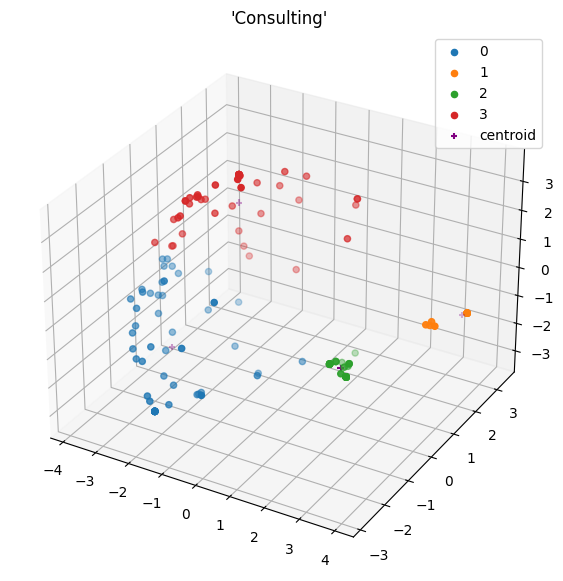

C:\Users\amrmn\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


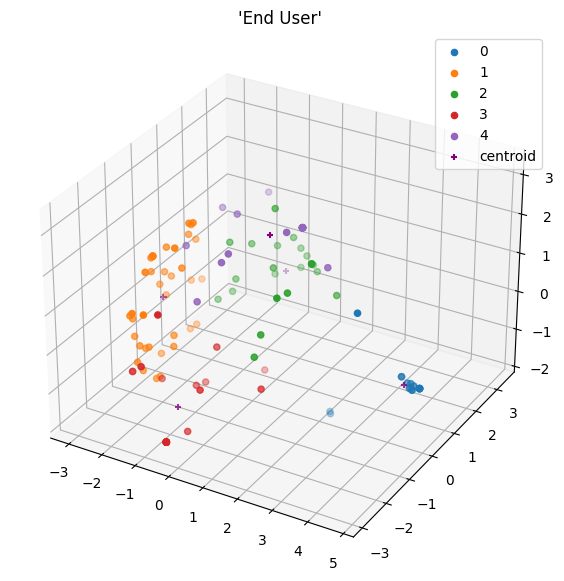

C:\Users\amrmn\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


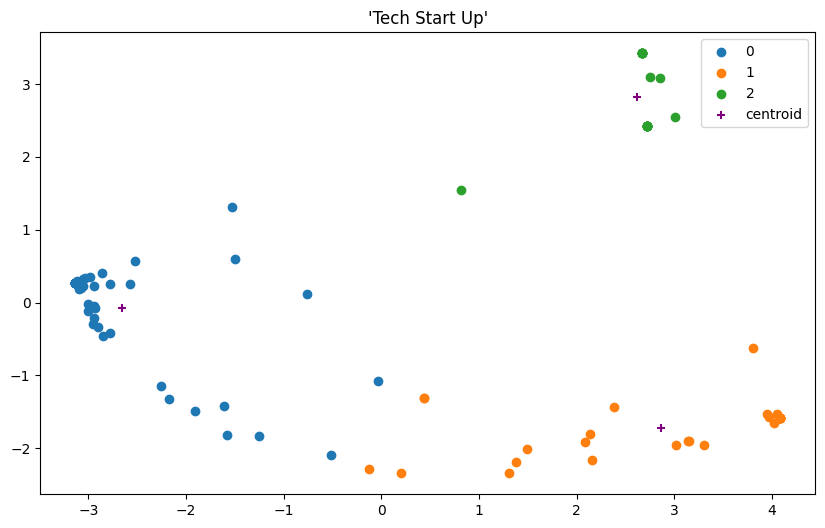

In [12]:
df_Skills = {}
kmeans = {}
for j_category in ['Consulting', 'End User', 'Tech Start Up']:
    if j_category == 'Consulting': 
        #Initialize the class object
        kmeans[j_category] = KMeans(n_clusters= 4)
        #predict the labels of clusters.
        transform = transform_dim3[j_category]
        label = kmeans[j_category].fit_predict(transform)
        #Getting unique labels
        u_labels = np.unique(label)
        data={'Name':mtx[j_category].index,'Cluster':label}
        df_Skills[j_category]=pd.DataFrame(data)

        kmeans[j_category].cluster_centers_
        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")
        for i in u_labels:
            ax.scatter(transform[label == i , 0] , transform[label == i , 1], transform[label == i , 2] , label = i)
        ax.scatter(kmeans[j_category].cluster_centers_[:,0],kmeans[j_category].cluster_centers_[:,1], kmeans[j_category].cluster_centers_[:,2], color='purple',marker='+',label='centroid')
        ax.legend()
        plt.title("'{}'".format(j_category))
        plt.savefig('cluster.png')
        plt.show()
        df_Skills[j_category].to_csv("Job_Skills_Clusters_'{}'.csv".format(j_category))

    if j_category == 'End User': 
        #Initialize the class object
        kmeans[j_category] = KMeans(n_clusters= 5)
        #predict the labels of clusters.
        transform = transform_dim3[j_category]
        label = kmeans[j_category].fit_predict(transform)
        #Getting unique labels
        u_labels = np.unique(label)
        data={'Name':mtx[j_category].index,'Cluster':label}
        df_Skills[j_category]=pd.DataFrame(data)

        kmeans[j_category].cluster_centers_
        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")
        for i in u_labels:
            ax.scatter(transform[label == i , 0] , transform[label == i , 1], transform[label == i , 2] , label = i)
        ax.scatter(kmeans[j_category].cluster_centers_[:,0],kmeans[j_category].cluster_centers_[:,1], kmeans[j_category].cluster_centers_[:,2], color='purple',marker='+',label='centroid')
        ax.legend()
        plt.title("'{}'".format(j_category))
        plt.savefig('cluster.png')
        plt.show()
        df_Skills[j_category].to_csv("Job_Skills_Clusters_'{}'.csv".format(j_category))

    if j_category == 'Tech Start Up': 
        #Initialize the class object
        kmeans[j_category] = KMeans(n_clusters= 3)
        #predict the labels of clusters.
        transform = transform_dim2[j_category]
        label = kmeans[j_category].fit_predict(transform)
        #Getting unique labels
        u_labels = np.unique(label)
        data={'Name':mtx[j_category].index,'Cluster':label}
        df_Skills[j_category]=pd.DataFrame(data)

        kmeans[j_category].cluster_centers_
        #plotting the results:
        plt.figure(figsize=(10,6))
        for i in u_labels:
            plt.scatter(transform[label == i , 0] , transform[label == i , 1] , label = i)
        plt.scatter(kmeans[j_category].cluster_centers_[:,0],kmeans[j_category].cluster_centers_[:,1],color='purple',marker='+',label='centroid')
        plt.legend()
        plt.title("'{}'".format(j_category))
        plt.savefig('cluster.png')
        plt.show()
        df_Skills[j_category].to_csv("Job_Skills_Clusters_'{}'.csv".format(j_category))


In [61]:
#User enters the job category and the skill --> s/he would get the 5 most similar skills to the one s/he entered
get_recommendations('PYTHON', df_sim, 'Tech Start Up')

PANDAS
REACT
AWS
R
SQL


### Network Analysis

In [4]:
## BIPARTITE GRAPH
# nodes 0: candidates
# nodes 1: institutions

In [ ]:
data = pd.read_csv("bipartite_data.csv", encoding="ISO-8859-1")
data.head()

In [6]:
F = nx.Graph()
for item in data.iterrows():
    #print(item[1][0], item[1][1]) 
    F.add_node(item[1][0], bipartite=0, type='candidate')
    
    F.add_node(item[1][1], bipartite=1, type='institution')
    
    if F.has_edge(item[1][0], item[1][1]):
        continue 
        
    else:
        F.add_edge(item[1][0], item[1][1])
# save the graph
nx.write_gexf(F,'bipartite.gexf')

In [7]:
## PROJECTION ON REFERENCES
# nodes: reference institutions
# weight: number of candidates who put the two institution together as ref

In [8]:
bottom_nodes = []
for (p, d) in F.nodes(data=True):
    if d['type'] == 'institution':
        #add degree from bipartite network as attribute
        d['bipartite_degree'] = F.degree[p]
        #append to bottom_nodes
        bottom_nodes.append(p)

projected_on_references = bipartite.weighted_projected_graph(F, bottom_nodes, ratio=False)
nx.write_gexf(projected_on_references,'projected_on_references.gexf')